Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


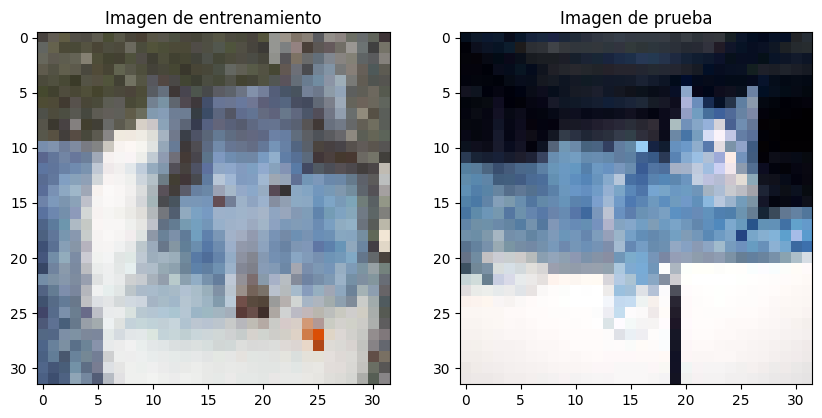

X_train shape: (3200, 32, 32, 3), y_train shape: (3200, 2)
X_val shape: (800, 32, 32, 3), y_val shape: (800, 2)
X_test shape: (1000, 32, 32, 3), y_test shape: (1000, 2)
Epoch 1/10
100/100 [==============================] - 6s 48ms/step - loss: 0.6922 - accuracy: 0.5288 - val_loss: 0.6726 - val_accuracy: 0.6000
Epoch 2/10
100/100 [==============================] - 5s 48ms/step - loss: 0.6661 - accuracy: 0.5922 - val_loss: 0.6338 - val_accuracy: 0.6338
Epoch 3/10
100/100 [==============================] - 7s 68ms/step - loss: 0.6368 - accuracy: 0.6322 - val_loss: 0.6018 - val_accuracy: 0.6463
Epoch 4/10
100/100 [==============================] - 5s 49ms/step - loss: 0.5945 - accuracy: 0.6797 - val_loss: 0.5915 - val_accuracy: 0.6762
Epoch 5/10
100/100 [==============================] - 5s 51ms/step - loss: 0.5283 - accuracy: 0.7381 - val_loss: 0.7324 - val_accuracy: 0.5987
Epoch 6/10
100/100 [==============================] - 6s 63ms/step - loss: 0.4861 - accuracy: 0.7603 - val_loss: 0.5

In [2]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from google.colab import drive  # Importa la biblioteca google.colab.drive

# Montar la unidad de Google Drive
drive.mount('/content/drive')

# Función para cargar y redimensionar las imágenes
def cargar_imagenes_directorio(directorio, tamano=(32, 32)):
    imagenes = []
    labels = []

    for filename in os.listdir(directorio):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(directorio, filename))
            img = cv2.resize(img, tamano)
            imagenes.append(img)

            # La clase está en el nombre del archivo: dog.XXXX.jpg o cat.XXXX.jpg
            label = 1 if filename.split('.')[0] == 'dog' else 0
            labels.append(label)

    return np.array(imagenes), np.array(labels)

# Directorios de entrenamiento y prueba
train_directories = ['/content/drive/MyDrive/datasets/data/github_train_0',
                     '/content/drive/MyDrive/datasets/data/github_train_1',
                     '/content/drive/MyDrive/datasets/data/github_train_2',
                     '/content/drive/MyDrive/datasets/data/github_train_3']
test_directory = '/content/drive/MyDrive/datasets/data/github_test'

# Cargar imágenes de entrenamiento
X_train = []
y_train = []

for directory in train_directories:
    imagenes, labels = cargar_imagenes_directorio(directory)
    X_train.append(imagenes)
    y_train.append(labels)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Cargar imágenes de prueba
X_test, y_test = cargar_imagenes_directorio(test_directory)

# Normalizar los valores de píxeles a valores entre 0 y 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Dividir el conjunto de entrenamiento en train y validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convertir las etiquetas a formato one-hot encoding
num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Visualización del dataset
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title('Imagen de entrenamiento')
plt.subplot(1, 2, 2)
plt.imshow(X_test[0])
plt.title('Imagen de prueba')
plt.show()

# Análisis de datos
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# Construcción del modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.3f}')
print(f'Test accuracy: {accuracy:.3f}')

In [4]:
# Evaluar el modelo
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Reporte de clasificación
print(classification_report(y_test_binary, y_pred))

32/32 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       500
           1       0.70      0.80      0.75       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



In [6]:
# Importar la función confusion_matrix
from sklearn.metrics import confusion_matrix


# Matriz de confianza
print(confusion_matrix(y_test_binary, y_pred))


[[327 173]
 [100 400]]


El modelo de aprendizaje profundo ha sido entrenado con éxito y ha logrado una precisión del 73% en el conjunto de prueba.



# Paso 5.



1.   Obtener las predicciones del modelo para el conjunto de prueba.
2.   Identificar las imágenes mal clasificadas.
3.   Ordenar las imágenes mal clasificadas por el nivel de confianza de la predicción incorrecta.
4.   Seleccionar el 10% de las imágenes mal clasificadas con mayor nivel de confianza.






In [7]:
# Obtener las predicciones del modelo para el conjunto de prueba
y_pred = model.predict(X_test)

# Identificar las imágenes mal clasificadas
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
misclassified_indices = np.where(y_pred_labels != y_test_labels)[0]

# Ordenar las imágenes mal clasificadas por el nivel de confianza de la predicción incorrecta
misclassified_confidences = [max(y_pred[i]) for i in misclassified_indices]
sorted_indices = np.argsort(misclassified_confidences)[::-1]
misclassified_indices = [misclassified_indices[i] for i in sorted_indices]

# Seleccionar el 10% de las imágenes mal clasificadas con mayor nivel de confianza
num_misclassified = len(misclassified_indices)
num_to_select = int(num_misclassified * 0.1)
selected_indices = misclassified_indices[:num_to_select]

# Obtener las imágenes seleccionadas
selected_images = X_test[selected_indices]

32/32 [==============================] - 1s 35ms/step


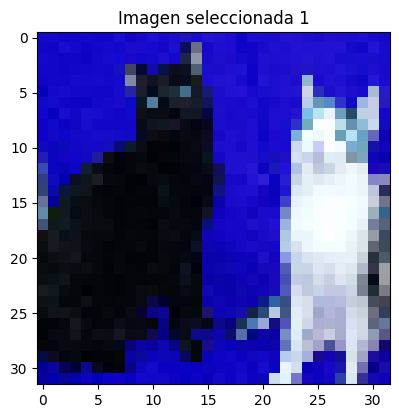

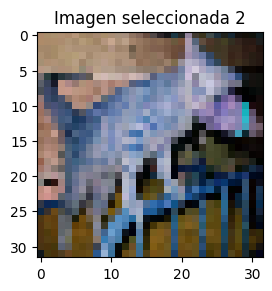

In [8]:
# Mostrar un par de ejemplos de selected_images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(selected_images[0])
plt.title('Imagen seleccionada 1')
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(selected_images[1])
plt.title('Imagen seleccionada 2')
plt.show()